# Inverse Propensity Score

One of the most fundamental features of _RecoGym_ is the ability to collect logs of applying a specific agent in the _RecoGym_ environment. That opens a plethora of opportunities to examine machine learning based on _Counterfactual Risk Minimization_ and compare the result with machine learning based on _Empirical Risk Minimization_.

In _[Likelihood Agents](./Likelihood%20Agents.ipynb)_ notebook, some _Agents_ those use different feature sets for _Liklihood_ model have already been analysed. In this notebook, we consider _Inverse Propensity Score_ that is a part of _Counterfactual Risk Minimization_ approach.

# The Data

In [26]:
import gym, reco_gym
from copy import deepcopy
from reco_gym import env_1_args
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook
plt.rcParams['figure.figsize'] = [8, 4]

ABTestNumberOfUsers = 10000
RandomSeed = 42

NumberOfProducts = 10

env_1_args['random_seed'] = RandomSeed
env_1_args['num_products'] = NumberOfProducts
env_1_args['K'] = 5
env_1_args['sigma_omega'] = 10
env_1_args['number_of_flips'] = 1
env_1_args['num_epochs'] = 100


env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [14]:
data = deepcopy(env).generate_logs(ABTestNumberOfUsers)

In [15]:
print("Data:\n", data[:20])
print("Data Shape:\n", data.shape)

Data:
      t  u        z    v    a    c   ps
0    0  0  organic  4.0  NaN  NaN  NaN
1    1  0   bandit  NaN  3.0  0.0  0.1
2    2  0   bandit  NaN  4.0  0.0  0.1
3    3  0   bandit  NaN  5.0  0.0  0.1
4    0  1  organic  4.0  NaN  NaN  NaN
5    1  1   bandit  NaN  2.0  0.0  0.1
6    2  1   bandit  NaN  8.0  0.0  0.1
7    3  1   bandit  NaN  4.0  0.0  0.1
8    4  1  organic  9.0  NaN  NaN  NaN
9    5  1  organic  9.0  NaN  NaN  NaN
10   6  1  organic  4.0  NaN  NaN  NaN
11   7  1  organic  4.0  NaN  NaN  NaN
12   8  1  organic  4.0  NaN  NaN  NaN
13   9  1  organic  7.0  NaN  NaN  NaN
14  10  1  organic  7.0  NaN  NaN  NaN
15  11  1  organic  7.0  NaN  NaN  NaN
16  12  1  organic  7.0  NaN  NaN  NaN
17  13  1  organic  6.0  NaN  NaN  NaN
18  14  1  organic  7.0  NaN  NaN  NaN
19  15  1  organic  7.0  NaN  NaN  NaN
Data Shape:
 (1007437, 7)


Details regarding the content of the data you shall find in _[Likelihood Agents](./Likelihood%20Agents.ipynb)_ notebook.

Please, note that there is a column _**`ps`**_ that is a _Probability Score_ of selecting a particular _`Action`_ by an _`Agent`_. Since the default _`Agent`_ selects an _`Action`_ _**randomly**_ and as there are _`10`_ different _`Actions`_ in overall, the _Probability Score_ is always $\frac{1}{10}$ = _`0.1`_ for all _Bandit_ _`Events`_.

# Multi-Class Classification Models

All models analised below use _Multi-Class Classification_ where for a provided set of features, the models predict an _`Action`_.

That approach differs to what was used in _Logistic Regression_ for _Emirical Risk Minimization_ where an _`Action`_ was a part of input features.

In [16]:
import math
import numpy as np

def build_train_data(
    data,
    weight_history_function = None
):
    """
    Build Train Data

        Parameters:
            data: offline experiment logs
                the data contains both Organic and Bandit Events
            weight_history_function(function): weight functions that assigns an appropriate weight
                for View in Organic Event for a certain Product

        Returns:
            :(features, outs)
    """
    num_products = int(data.v.max() + 1)
    number_of_users = int(data.u.max()) + 1

    features = []
    actions = []
    pss = []
    clicks = []

    for user_id in range(number_of_users):
        views = np.zeros((0, num_products))
        for _, user_datum in data[data['u'] == user_id].iterrows():
            if user_datum['z'] == 'organic':
                assert (math.isnan(user_datum['a']))
                assert (math.isnan(user_datum['c']))
                assert (not math.isnan(user_datum['v']))

                view = int(user_datum['v'])

                tmp_view = np.zeros(num_products)
                tmp_view[view] = 1

                # Append the latest view at the beginning of all views.
                views = np.append(tmp_view[np.newaxis, :], views, axis = 0)
            else:
                assert (user_datum['z'] == 'bandit')
                assert (not math.isnan(user_datum['a']))
                assert (not math.isnan(user_datum['c']))
                assert (math.isnan(user_datum['v']))

                action = int(user_datum['a'])
                click = int(user_datum['c'])
                ps = int(user_datum['ps'])

                if weight_history_function is None:
                    train_views = views
                else:
                    history = np.array(range(views.shape[0])).reshape(views.shape[0], 1)
                    weights = weight_history_function(history)
                    train_views = views * weights

                feature = np.sum(train_views, axis = 0)

                features.append(feature)
                actions.append(action)
                clicks.append(click)
                pss.append(ps)

    return np.array(features), np.array(actions), np.array(clicks), np.array(pss)

## Logistic Regression with Wieghted Training Data

The model is based on _Logistic Regression_ of multiple classes (different _`Actions`_) where during training each feature set will be weighted. The weight for $i^th$ feature set is actually _Inverse Propensity Score_ that is calculated as follows:



$$ w_i \equiv ips_i = \frac{\delta_i}{p_i} $$

* $
\delta_i =
\begin{cases}
    1,& \text{if there is a click}\\
    0,& \text{otherwise}
\end{cases}
$
* $p_i$ is a _Probability Score_ that is for the case of _Random_ _`Agent`_ is _**always**_ _`0.1`_.

In [22]:
train_features01, train_actions01, train_clicks01, train_pss01 = build_train_data(data)

random_ps = 1.0 / NumberOfProducts
train_weights01 = train_clicks01 / random_ps

from sklearn.linear_model import LogisticRegression

logreg_weighted01 = LogisticRegression(
    solver = 'lbfgs',
    max_iter = 5000,
    multi_class='multinomial',
    random_state = RandomSeed
)

lr_weighted01 = logreg_weighted01.fit(train_features01, train_actions01, train_weights01)

In [18]:
lr_weighted01.coef_

array([[ 0.03143925,  0.00050322, -0.04328292, -0.01821969, -0.01245912,
         0.00326523, -0.02487934, -0.01485542,  0.00091738,  0.00459777],
       [ 0.01502918,  0.03799204, -0.00440879, -0.0730862 ,  0.00147859,
        -0.02575392,  0.02721495,  0.00549989,  0.00192839, -0.00032049],
       [-0.01166192, -0.03017913,  0.00493422,  0.01168987,  0.00172708,
         0.01183573, -0.02356884, -0.0018574 , -0.01997583,  0.00719248],
       [-0.03847182, -0.0045877 ,  0.00813745,  0.0326699 ,  0.00918781,
         0.00698064, -0.00053606,  0.00270745,  0.00755967,  0.00958373],
       [-0.00373939, -0.00547396,  0.00957473,  0.00965566,  0.00977578,
         0.01531832, -0.00044246, -0.01068688,  0.00188647, -0.00923969],
       [ 0.00674602, -0.01507181,  0.00417896,  0.02631447, -0.00030121,
         0.02166906, -0.01022581, -0.00644927, -0.03455322, -0.00229024],
       [ 0.00142387,  0.04747141,  0.00381171, -0.06389888,  0.00248607,
        -0.01828761,  0.02723367,  0.02743742

Let's check how the model works if in _`Views`_ thare are _`10`_s for each _`Product`_.

In [19]:
test_views01 = np.zeros((NumberOfProducts, NumberOfProducts))
for product_id in range(NumberOfProducts):
    test_views01[product_id, product_id] = 10
print("Predicted Action: ", lr_weighted01.predict(test_views01))
print("Predicted Probability of Actions: ", lr_weighted01.predict_proba(test_views01))

Predicted Action:  [0 9 5 5 4 5 4 5 9 2]
Predicted Probability of Actions:  [[0.15215105 0.08840022 0.1023193  0.04675628 0.11189029 0.13449847
  0.06073091 0.07137877 0.10175872 0.130116  ]
 [0.11585906 0.11539535 0.08821589 0.06807777 0.11409531 0.11219467
  0.09986199 0.06835182 0.08843702 0.12951111]
 [0.07387185 0.07460255 0.12380893 0.07638002 0.13101868 0.13436528
  0.06375267 0.094522   0.10424091 0.12343711]
 [0.08741949 0.03457582 0.12200354 0.08990915 0.12077184 0.15441922
  0.02983431 0.09805254 0.12758278 0.13543131]
 [0.10142261 0.07982004 0.12095207 0.077863   0.13243296 0.12960437
  0.0634645  0.08640571 0.10555421 0.10248052]
 [0.11428661 0.05853468 0.12885023 0.07333581 0.13478379 0.15545543
  0.0496458  0.09153026 0.07369898 0.1198784 ]
 [0.09074429 0.10459438 0.09514355 0.07156913 0.12112776 0.11888923
  0.08234423 0.1083319  0.09381067 0.11344486]
 [0.10013769 0.08403226 0.1180092  0.07380012 0.10914344 0.12325051
  0.08236885 0.11468096 0.08544416 0.1091328 ]
 [0.

As you can see, only _`Products`_ _`1`_, _`4`_, _`5`_, _`7`_, and _`9`_ correlate with amount of appropriate _`Views`_.

Let's build a graph to reveal the correlation of matched products with the appropriate amount of _`Views`_.

<IPython.core.display.Javascript object>


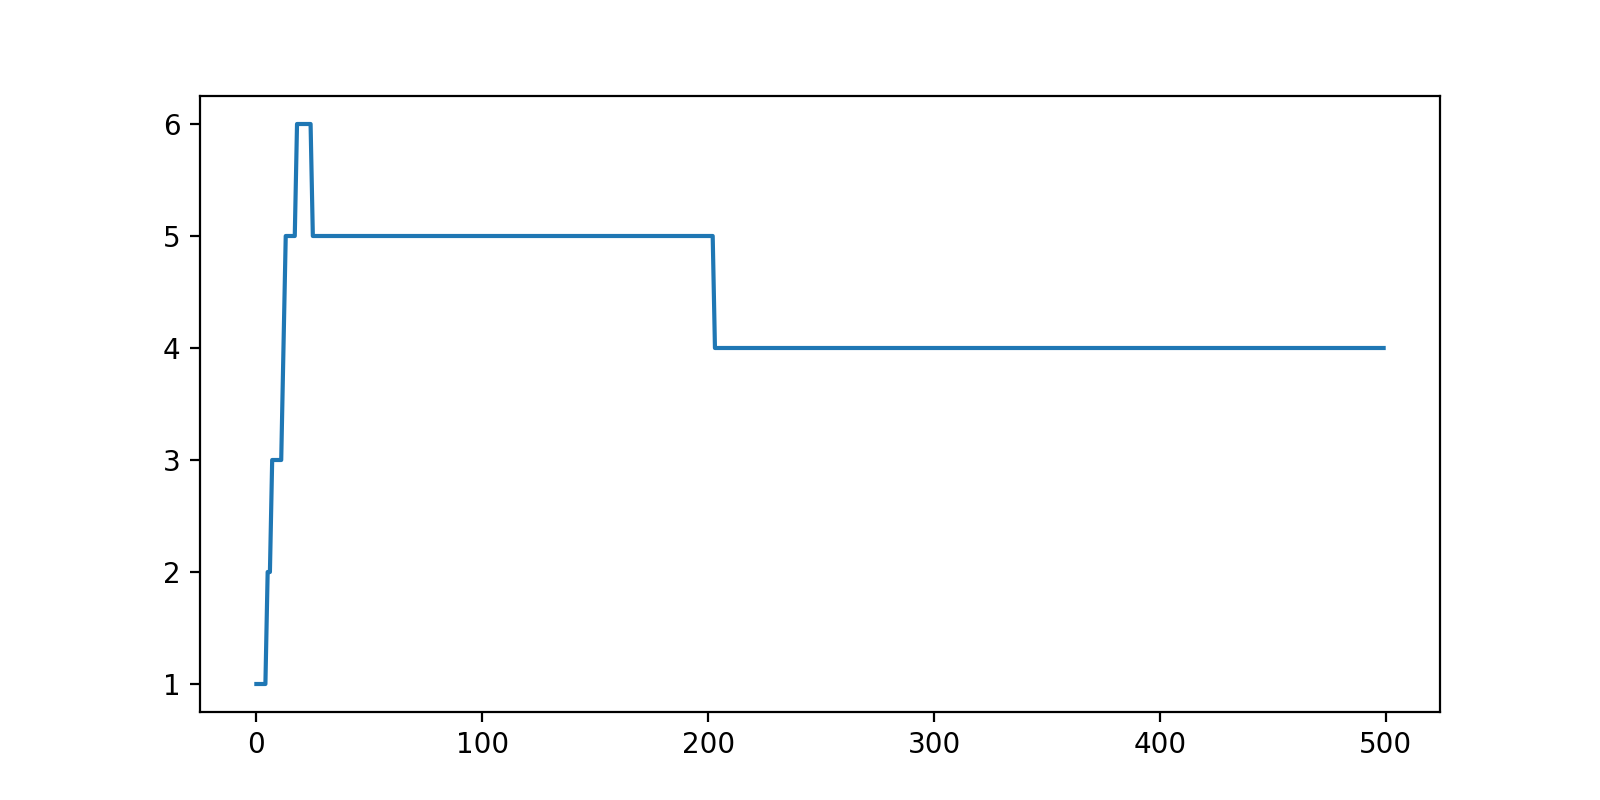

In [20]:
all_product_ids = np.array(range(NumberOfProducts))
inc_matrix = np.eye(NumberOfProducts)
views = np.zeros((NumberOfProducts, NumberOfProducts))
counts = []
matcheses = []
for count in range(200):
    views += inc_matrix
    predictions = lr_weighted01.predict(views)
    matches = np.sum(predictions == all_product_ids)
    matcheses.append(matches)
    counts.append(count)

_, ax = plt.subplots()
ax.plot(counts, matcheses)
plt.show()

As you can see, the picture is pretty stable and the model is not reliable.
Now, let's build a more sophisticated model with product crossfitting.

In [21]:
from sklearn.preprocessing import PolynomialFeatures

logreg_weighted02 = LogisticRegression(
    solver = 'lbfgs',
    max_iter = 10000,
    multi_class='multinomial',
    random_state = RandomSeed
)
poly2 = PolynomialFeatures(2)
lr_weighted02 = logreg_weighted02.fit(poly2.fit_transform(train_features01), train_actions01, train_weights01)

<IPython.core.display.Javascript object>


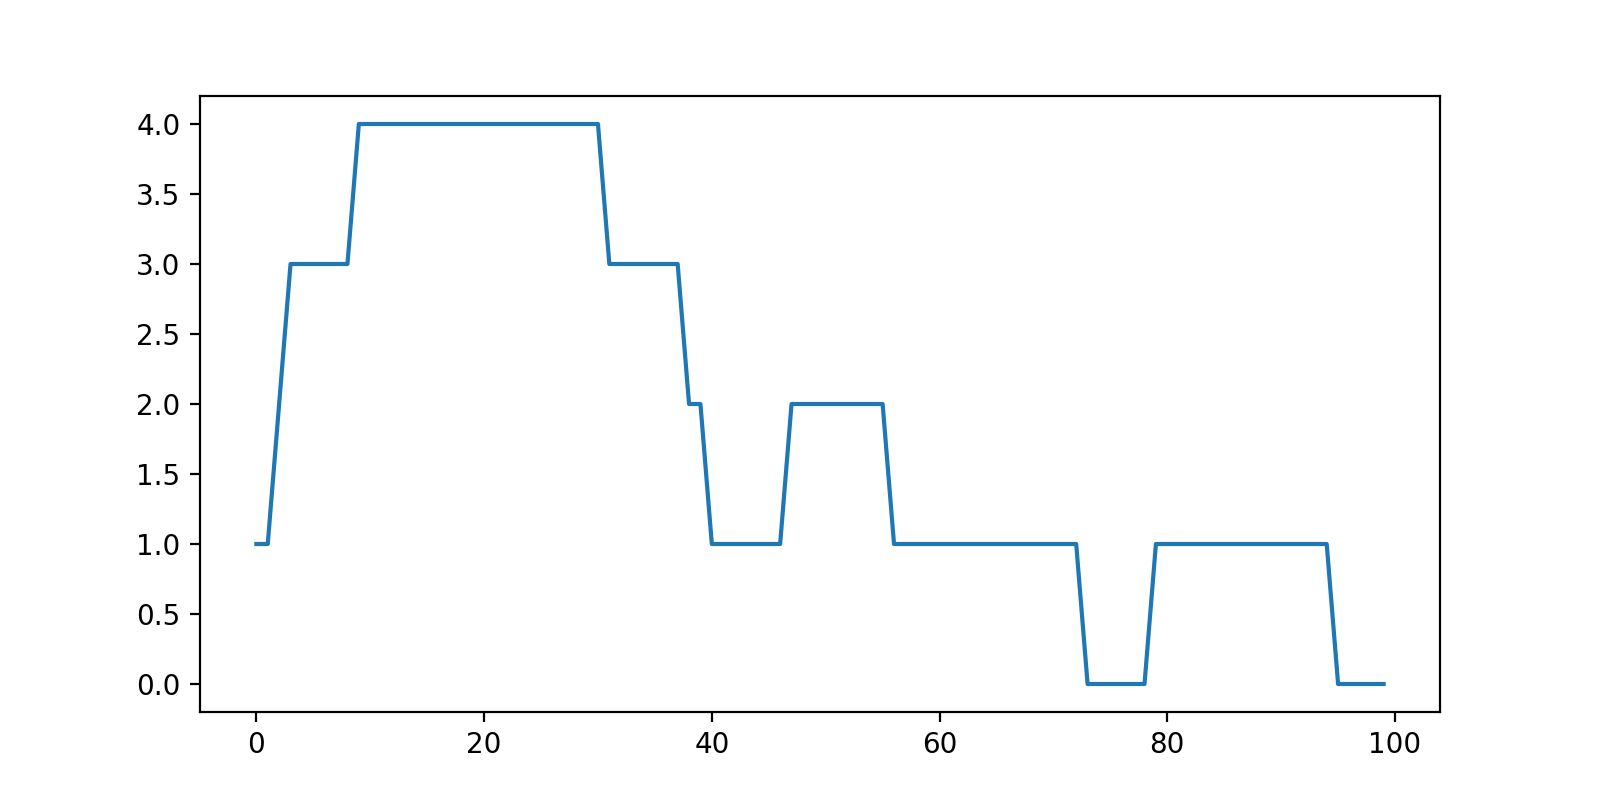

In [19]:
views = np.zeros((NumberOfProducts, NumberOfProducts))
counts = []
matcheses = []
for count in range(200):
    views += inc_matrix
    predictions = lr_weighted02.predict(poly2.fit_transform(views))
    matches = np.sum(predictions == all_product_ids)
    matcheses.append(matches)
    counts.append(count)

_, ax = plt.subplots()
ax.plot(counts, matcheses)
plt.show()

At this moment, it is not clear yet how the model behavies and what kind of performance in _Click-Through Rate_ shall we expect. To reveal that, we bench the _`Agent`_ that uses the model.

## Hypothesis with Inversed Propensity Score

So far, _[scikit-learn](https://scikit-learn.org)_ was used to create models. This time, we are going to build a more complicated model based on a _Neural Network_. The model implements a new hypothesis $h_c(A=a|V)$ that for given _`Views`_ finds _the probability of the click_ for an _`Action`_ $a$. The value of that function is _Probability Score_ that is stored by _RecoGym_ in offline logs.

At this time, we will use _[PyTorch](https://pytorch.org)_ to train models.

$$
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator{\Var}{Var}
\hat{R}^{M}(h_c) = \frac{1}{n} \sum_{i}^{N}\delta_{i} \min \left \{ M, \frac{h_c(A = a_i|V_i)}{p_i} \right \}
$$

$$
u_i = \delta_i \min \left \{ M, \frac{h_c(A = a_i|V_i)}{p_i} \right \}, \bar{u} = \frac{1}{N} \sum_{i}^{N} u_i
$$

$$
\Var_{h_c}(u) = \frac{1}{N - 1} \sum_{i}^{N} \left( u_i - \bar{u} \right)^2
$$

$$
\hat{h}_c^{CRM} = \argmin_{h \in \mathcal{H}} \left \{ \hat{R}^{M}(h_c) + \lambda \sqrt{\frac{\Var_{h_c}(u)}{N}} \right \} 
$$

In the new model, $\hat{h}_c^{CRM}$ is to be minimised, where:
* $\hat{h}_c^{CRM}$ is a new hypothesis that based on _Counterfactual Risk Minimization_
* $N$ is the number of training samples
* $p_i$ is a _Propensity Score_ or a probability of applying the default hypothesis $h_0$; in our case, it is always $\frac{1}{10}=0.1$
* $a_i$ is an _`Action`_ provided in the ith training sample
* $V_i$ _`Views`_ at ith training sample

In the new model, we also use a regularisation defined as: $\lambda \sqrt{\frac{\Var_{h_c}(u)}{N}}$.

The new hypothesis is implemented in a neural network.
The network has the following topology:
* _`2`_ sigmoid layers
* _`1`_ _softmax_ layer

More details about the structure of the NN, you shall find in _`NeuralNet`_ class.

The model used here was motivated by the article _[arXiv:1502.02362](https://arxiv.org/pdf/1502.02362.pdf)_.

## Comparing Agent Performance

Let's compare the performance of models with _IPS & Multi-Class Logistic Regression_ vs _IPS & Hypothesis implemented in Neural Network_.

In [25]:
import gym, reco_gym
from copy import deepcopy

from reco_gym import env_1_args, Configuration
from agents import LogregIpsAgent, logreg_ips_args
from agents import NnIpsAgent, nn_ips_args

NumberOfflineUsers = 10000
NumberTestUsers = 1000

test_env = {
    **env_1_args,
    **logreg_ips_args,
    **nn_ips_args,

    **{
        'random_seed': RandomSeed,
        'num_products': NumberOfProducts,
        'sigma_omega': 1,
        'number_of_flips': 1,
    }
}

env = gym.make('reco-gym-v1')
env.init_gym(test_env)

ImportError: cannot import name 'NnIpsAgent' from 'agents' (/Users/d.mykhaylov/dev/src/reco-gym.gitlab/agents/__init__.py)

In [23]:
stat01 = reco_gym.test_agent(
    deepcopy(env),
    LogregIpsAgent(Configuration(test_env)),
    NumberOfflineUsers,
    NumberTestUsers
)
print("IPS & Multi-Class Logistic Regression:\n", stat01)

Starting Agent Training
Starting Agent Testing
IPS & Multi-Class Logistic Regression:
 (0.012421649397702886, 0.01167662638498063, 0.013197303145929706)


In [24]:
stat02 = reco_gym.test_agent(
    deepcopy(env),
    NnIpsAgent(Configuration(test_env)),
    NumberOfflineUsers,
    NumberTestUsers
)
print("IPS & Hypothesis by Neural Network:\n", stat02)

NameError: name 'NnIpsAgent' is not defined

## Conclusion

$$  $$